Analytic solutions of viscoelastic fluids
======

This notebook outlines and solves for an analytic solution of a viscoelastic material undergoing simple shear. A discussion on the invariance of the stress tensor under rotation is presented with a three dimensional rotating test outlined.

**Simple shear in two dimensions**

This model compares the analytic to numeric stored stress of a viscoelastic material undergoing simple shear in two dimensions, as outlined in Farrington et al (2014). The vertical velocity boundary conditions are periodic, the bottom velocity bc is no-slip with a horizontal shear velocity bc applied to the top wall until $t = 1$.  For $t > 1$ the top wall velocity bc is no-slip and the stress is allowed to relax.

**References**

Farrington, R. J., L.-N. Moresi, and F. A. Capitanio (2014), The role of viscoelasticity in subducting plates, Geochem. Geophys. Geosyst., 15, 4291–4304, doi:10.1002/2014GC005507.

In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
uw.matplotlib_inline()

import matplotlib.pyplot as pyplot
pyplot.ion()  # don't hang on show() for pure python runs
import numpy as np
import math

import mpi4py
comm = mpi4py.MPI.COMM_WORLD

In [2]:
#Create mesh and finite element variables
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (16, 16), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.),
                                 periodic    = [True, False]  ) 

velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
pressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

In [3]:
#Apply conditions on the boundaries
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

shearVelocity = 0.05

for index in mesh.specialSets["MinJ_VertexSet"]:
    velocityField.data[index] = [0., 0.]
for index in mesh.specialSets["MaxJ_VertexSet"]:
    velocityField.data[index] = [shearVelocity, 0.]
    
periodicBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                               indexSetsPerDof = ( jWalls, jWalls) ) 

In [4]:
#Setup a swarm
swarm         = uw.swarm.Swarm( mesh=mesh )
swarmLayout   = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

In [5]:
# Add swarm variable
materialIndex  = swarm.add_variable( dataType="int",    count=1 )

viscoelastic = 0
viscoelastic_bar  = 1

xCoordFn = fn.input()[0]
conditions = [ ( ( xCoordFn > 0.4 ) & (xCoordFn < 0.6 ) , viscoelastic_bar),
               (  True                                  , viscoelastic )]

materialIndex.data[:]  = fn.branching.conditional( conditions ).evaluate(swarm)

# initialise swarm variables for viscoelastic rheology & analysis
previousStress         = swarm.add_variable( dataType="double", count=3 )
previousStress.data[:] = [0., 0., 0.]


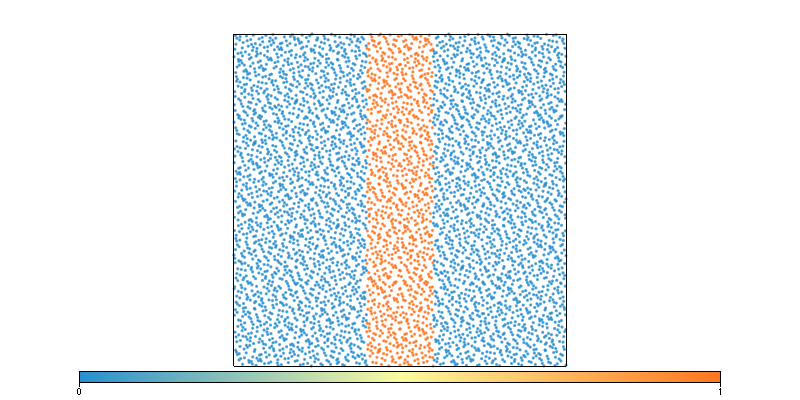

In [6]:
figMaterial = glucifer.Figure( figsize=(800,400) )
figMaterial.append( glucifer.objects.Points(swarm, materialIndex, pointSize=4.0) )
figMaterial.show()

In [7]:
## Define material parameters and observation time
eta     = 1.0e2  # viscosity
mu      = 1.0e2  # elastic modulus

alpha   = eta / mu                         # viscoelastic relaxation time
dt_e    = 0.1                      # elastic time step
eta_eff = ( eta * dt_e ) / (alpha + dt_e)  # effective viscosity

# define viscosity
viscosityFn = eta_eff

In [8]:
# define strain rate tensor
strainRate = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariant = fn.tensor.second_invariant(strainRate)

In [9]:
# define the viscoelastic stress tensor
viscousStressFn = 2. * viscosityFn * strainRate 
elasticStressFn = eta_eff / ( mu * dt_e ) * previousStress
stressFn        = viscousStressFn + elasticStressFn

In [10]:
# density
densityMapFn = fn.misc.constant( 1.0 )

# buoyancy force term
z_hat   = ( 0.0, 1.0 )
buoyancyFn = -densityMapFn * z_hat

In [11]:
# create stokes system, solver and advector
stokes = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               voronoi_swarm = swarm, 
                               conditions    = [periodicBC,],
                               fn_viscosity  = viscosityFn, 
                               fn_bodyforce  = buoyancyFn,
                               _fn_stresshistory = elasticStressFn)

solver = uw.systems.Solver( stokes )

advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

In [12]:
# define an update function
def update():
    # Retrieve the maximum possible timestep for the advection system.
    dt = advector.get_max_dt()
    # cap time step to 1/3 of the observation time 
    if dt > ( dt_e / 3. ):
        dt = dt_e / 3.  

    # Advect using this timestep size.
    advector.integrate(dt)
    
    # smoothed stress history for use in (t + 1) timestep   
    phi = dt / dt_e;
    stressFn_data = stressFn.evaluate(swarm)
    previousStress.data[:] = ( phi*stressFn_data[:] + ( 1.-phi )*previousStress.data[:] )
    
    return time+dt, step+1

In [13]:
# Stepping. Initialise time and timestep.
time = 0.
step = 0

# set time to shear
maxShearTime = 1.    # max time for shearing velocity BC
maxTime      = 10.

nsteps       = int(maxTime/dt_e*3.)+1        # number of steps to reach maxTime
velBCstep    = int(maxShearTime / (dt_e/3.)) # timestep of maxShearTime

# save stress history for plotting
tTracer           = np.zeros(nsteps)
previousStress_xy = np.zeros(nsteps)

In [14]:
# main time stepping loop
while time < maxTime :
    # output for analysis               
    tTracer[step] = time

    # keep record of the zeroth particle's shear stress...
    if comm.rank == 0:
        previousStress_xy[step] = previousStress[2].evaluate(swarm)[0]

    # solve stokes problem
    solver.solve()

    # We are finished with current timestep, update.
    time, step = update()
    
    # change BC if time > 1.0, then watch stress decay
    if step == velBCstep:
        for index in mesh.specialSets["MaxJ_VertexSet"]:
            velocityField.data[index] = [0.0, 0.]


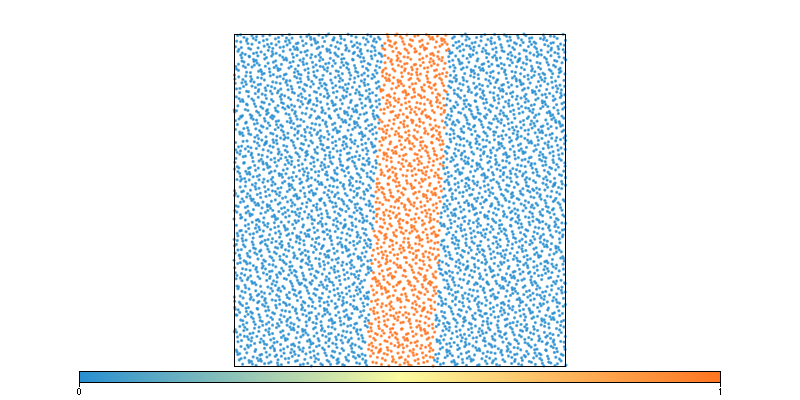

In [15]:
figMaterial.show()

In [16]:
# analytic soln of elastic shear stress component
V  = shearVelocity
h  = mesh.maxCoord[1] - mesh.minCoord[1]
C1 = -V*V*eta*eta*mu/(mu*mu*h*h + V*V*eta*eta);
C2 = -V*h*eta*mu *mu/(mu*mu*h*h + V*V*eta*eta);

increment =  301 #int(10 / (dt_e / 3.0) )
t = np.linspace(0, 10, increment)
analyticSoln = np.zeros(increment)

for i in range(1,int(increment)):
    if t[i] < maxShearTime:
        analyticSoln[i] = np.exp(-mu/eta*t[i])*(C2*np.cos(V*t[i]/h)-C1*np.sin(V*t[i]/h))-C2
    if t[i] >= maxShearTime:
        analyticSoln[i] =(np.exp(-mu/eta*maxShearTime)*(C2*np.cos(V*maxShearTime/h)-C1*np.sin(V*maxShearTime/h))-C2)*np.exp(-mu/eta*(t[i]-maxShearTime))

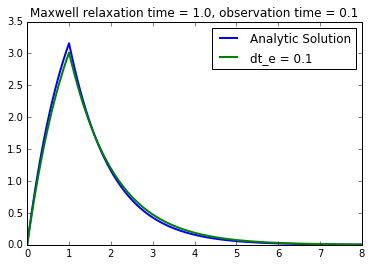

In [17]:
# plot elastic stress portion of total stress & analytic solution
if comm.rank == 0:

    pyplot.plot()
    pyplot.plot(t, analyticSoln, label='Analytic Solution', lw=2)
    pyplot.plot(tTracer, previousStress_xy, label='dt_e = '+str(dt_e), lw=2)
    pyplot.legend(loc='best')
    pyplot.axis([0, 8, 0, 3.5])
    pyplot.title('Maxwell relaxation time = 1.0, observation time = 0.1')

    pyplot.show()

**Numerical results compared to analytic solution**

The analytic solution shown above solves for the loading and exponental decay of the elastic stored stress component within a two dimensional viscoelastic material undergoing simple shear.  With an Maxwell relaxation time of 1 and an observation time of 0.1, the numerical model recovers the majority of the elastic stress.  Reducing the observation time further results in an even smaller difference from the numerical to analytic solutions. 

Increasing the observation time results in an increased viscous portion of the total stress, resulting in increased dissipative stress during the loading phase of the model, and corresponding decrease in stored stress to be released during the unloading phase.